In [133]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

### **Loading twitter dataset**

In [134]:
def load_data():
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  return df_train,df_test

In [135]:
df_train,df_test = load_data()
df_train = df_train[df_train['sentiment']!='neutral']
df_test = df_test[df_test['sentiment']!='neutral']
df_train.head()

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive


In [136]:
df_train.shape

(16363, 4)

### **Visualization of dataset**

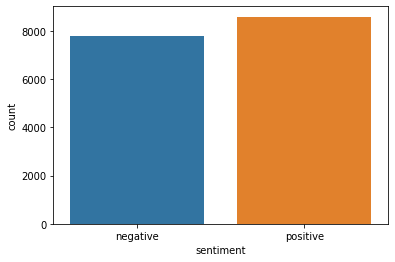

In [137]:
# Count plot to find the number of positive and negative tweets
sns.countplot(x = df_train['sentiment'])

**Number of positive and negative sentiments are almost equal**

### **Data cleaning**

In [138]:
import re

# Convert all charaters to lower case
def convert_to_lower(data):
  return data['text'].str.lower()

# remove all URLs present in the text
def remove_urls(data):
  return data['cleaned_text'].apply(lambda elem:re.sub(r"http\S+", "", str(elem)))

# remove all special characters
def remove_special_characters(data):
    data['cleaned_text'] = data['cleaned_text'].apply(lambda elem:re.sub(r'[^\w\s]', "", str(elem))) 
    data['cleaned_text'] = data['cleaned_text'].apply(lambda elem:re.sub(r'/n',"",str(elem)))
    data['cleaned_text'] = data['cleaned_text'].apply(lambda elem:re.sub(r'\d+',"",str(elem)))
    data['cleaned_text'] = data['cleaned_text'].apply(lambda elem:re.sub(r'\s+'," ",str(elem)))
    data['clean_text'] = data['cleaned_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",str(elem)))

    return data['cleaned_text']

In [139]:
def clean_text(train,test):
  train['cleaned_text'] = convert_to_lower(train)
  train['cleaned_text'] = remove_urls(train)
  train['cleaned_text'] = remove_special_characters(train)

  test['cleaned_text'] = convert_to_lower(test)
  test['cleaned_text'] = remove_urls(test)
  test['cleaned_text'] = remove_special_characters(test)

  return train,test

In [140]:
df_train1, df_test1 = clean_text(df_train,df_test) # text cleaning

In [141]:
df_train1.head()

,textID,text,selected_text,sentiment,cleaned_text,clean_text
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,sooo sad will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the rele...,sons of why couldnt they put them on the rele...
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,am feedings for the baby are fun when he is al...,am feedings for the baby are fun when he is al...


### **Text Processing**

In [142]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [143]:
# converting the cleaned text to a list of tokens
def tokenize(text):
  tokenizer = nlp.tokenizer
  tokens = tokenizer(text)
  return tokens

# removing the stop words as they carry little meaning in this case
def remove_stopwords(tokens):
  sw = nlp.Defaults.stop_words
  return " ".join([str(word) for word in tokens if not word in sw])

In [144]:
df_train1['cleaned_text']=df_train1['cleaned_text'].apply(lambda x:remove_stopwords(tokenize(x)))
df_test1['cleaned_text']=df_test1['cleaned_text'].apply(lambda x:remove_stopwords(tokenize(x)))

In [145]:
df_train1.head()

,textID,text,selected_text,sentiment,cleaned_text,clean_text
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,sooo sad will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could nt they put them on the re...,sons of why couldnt they put them on the rele...
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,am feedings for the baby are fun when he is al...,am feedings for the baby are fun when he is al...


In [146]:
# Converting the words to their base form (lemma)
def lemmatize(text):
  tokens = tokenize(text)
  return " ".join([str(token.lemma_) for token in tokens])

In [147]:
df_train1['cleaned_text'] = df_train1['cleaned_text'].apply(lambda x:lemmatize(x))
df_test1['cleaned_text'] = df_test1['cleaned_text'].apply(lambda x:lemmatize(x))

In [148]:
df_train1.head()

,textID,text,selected_text,sentiment,cleaned_text,clean_text
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,sooo sad will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss be bully me,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son of why can not they put them on the rel...,sons of why couldnt they put them on the rele...
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,be feeding for the baby be fun when he be all ...,am feedings for the baby are fun when he is al...


### **Text to Sequence conversion**

In [149]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# converting the text to numeric sequences for keras model
def text_to_sequence(data):
  tokenizer = Tokenizer(num_words=100000,split=' ')
  tokenizer.fit_on_texts(data['cleaned_text'].values)
  X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
  X = pad_sequences(X,maxlen=25,padding='post')

  return X,tokenizer

**Label encoding of target column**

In [150]:
from sklearn import preprocessing

# label encoding of target variable(0 for negative and 1 for positive)
def label_encoding(data):
  label_encoder = preprocessing.LabelEncoder()
  return label_encoder.fit_transform(data)

In [151]:
X,tokenizer = text_to_sequence(df_train1)
Y = label_encoding(df_train1['sentiment'].values)

### **Splitting of train and test data**

In [152]:
from sklearn.model_selection import train_test_split

# splitting the data into two sets: train and test data
X,X_test,Y,Y_test = train_test_split(X,Y,test_size = 0.2)

In [153]:
X.shape,Y.shape

((13090, 25), (13090,))

In [154]:
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense, Flatten, Dropout , Bidirectional , Dropout,GlobalMaxPooling1D,Input

# keras model for sentiment prediction
def Model():
  embed_dim = 100
  vocab_size = len(tokenizer.index_word)+1

  # sequential model
  model = Sequential()

  model.add(Input(shape=(25,)))
  # embedding layer
  model.add(Embedding(vocab_size,embed_dim,input_length=25))
  model.add(LSTM(16))
  # dropout layer to reduce overfitting
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))

  # final output layer 
  model.add(Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam()
  # compiling of classification model
  model.compile(loss="binary_crossentropy", optimizer=opt,metrics = ['accuracy'])
  return model

In [155]:
model = Model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 100)           1631800   
                                                                 
 lstm_7 (LSTM)               (None, 16)                7488      
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,639,865
Trainable params: 1,639,865
Non-trainable params: 0
_________________________________________________________________


In [156]:
def train_model(model):
  # cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode = 'min',patience=3,verbose=1)
  history = model.fit(X, Y, epochs = 10,batch_size=100, validation_data = (X_test,Y_test), verbose = 1)
  return history

In [157]:
history = train_model(model) # model training

Epoch 1/10
131/131 [==============================] - 6s 34ms/step - loss: 0.5252 - accuracy: 0.7101 - val_loss: 0.3512 - val_accuracy: 0.8533
Epoch 2/10
131/131 [==============================] - 4s 30ms/step - loss: 0.2568 - accuracy: 0.9085 - val_loss: 0.3250 - val_accuracy: 0.8640
Epoch 3/10
131/131 [==============================] - 4s 30ms/step - loss: 0.1624 - accuracy: 0.9471 - val_loss: 0.3482 - val_accuracy: 0.8570
Epoch 4/10
131/131 [==============================] - 4s 30ms/step - loss: 0.1198 - accuracy: 0.9636 - val_loss: 0.3993 - val_accuracy: 0.8537
Epoch 5/10
131/131 [==============================] - 4s 30ms/step - loss: 0.0912 - accuracy: 0.9726 - val_loss: 0.4770 - val_accuracy: 0.8518
Epoch 6/10
131/131 [==============================] - 4s 30ms/step - loss: 0.0740 - accuracy: 0.9789 - val_loss: 0.5994 - val_accuracy: 0.8390
Epoch 7/10
131/131 [==============================] - 4s 30ms/step - loss: 0.0662 - accuracy: 0.9799 - val_loss: 0.5718 - val_accuracy: 0.8372

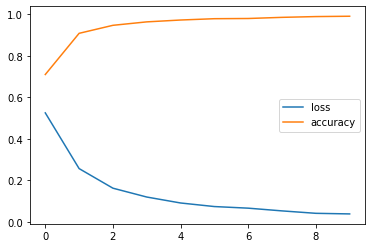

In [158]:
# plotting of accuracy and loss against number of epochs

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['loss','accuracy'])
plt.show()

### **Confusion matrix and classification report**

Text(0.5, 257.44, 'Predicted label')

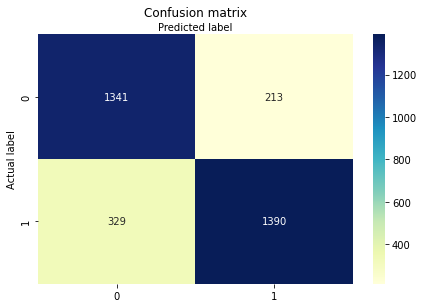

In [159]:
from sklearn.metrics import classification_report,confusion_matrix

# Classification report to analyze the values of true positives, false positives, true negatives and false negatives

pred= model.predict(X_test)
pred= [1 if i >0.5 else 0 for i in pred]

conf = confusion_matrix(Y_test,pred)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(conf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [160]:
# classification report to analyze the values of precision, recall, f1 score and accuracy

print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1554
           1       0.87      0.81      0.84      1719

    accuracy                           0.83      3273
   macro avg       0.84      0.84      0.83      3273
weighted avg       0.84      0.83      0.83      3273



### **Saving the model**

In [161]:
import pickle

with open('model.sav','wb') as file:
  pickle.dump(model,file)

INFO:tensorflow:Assets written to: ram://087ab995-1be5-4b02-b91a-3017f3ea5639/assets


INFO:tensorflow:Assets written to: ram://087ab995-1be5-4b02-b91a-3017f3ea5639/assets


In [162]:
model = pickle.load(open('model.sav','rb'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 100)           1631800   
                                                                 
 lstm_7 (LSTM)               (None, 16)                7488      
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,639,865
Trainable params: 1,639,865
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [164]:
print(tokenizer)

### **Saving the tokenizer**

In [165]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
print(tokenizer)